In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import os

from sklearn.model_selection import train_test_split
from scipy.stats import ttest_rel
from itertools import chain, combinations

# styling:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use(['ggplot'])
sns.set_palette("deep")

In [ ]:
perturbation_factor = 3.0
def choose_2_3(iterable):
    "powerset([1,2,3]) -->  (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(2,4))

In [ ]:
exp_name_df = pd.read_csv('./data/bsubtilis/exp_names.tsv', index_col=0, sep='\t', names=['name'])
network_df = pd.read_csv('./data/bsubtilis/gold_standard.tsv', sep='\t', index_col=0)
multi_tf_network_df = network_df.loc[(network_df.sum(axis=1).sort_values(ascending=False) > 4)]
multi_tf_targets = multi_tf_network_df.index
tf_names = multi_tf_network_df.columns.values

In [ ]:
exp_genes_set = set(multi_tf_targets).union(set(tf_names))
common_tf_gene = set(multi_tf_targets).intersection(set(tf_names))
for subdir, dirs, files in os.walk('./data/bsubtilis/seq_data/'):
    for file in files:
        df = pd.read_csv(os.path.join(subdir, file), index_col=0, sep='\t', names=['exp'])
        exp_genes_set = exp_genes_set.intersection(set(df.index))

In [ ]:
exp_df = pd.DataFrame(index=exp_genes_set)

In [ ]:
for subdir, dirs, files in os.walk('./data/bsubtilis/seq_data/'):
    for code_name, exp_name in zip(exp_name_df.index, exp_name_df['name'].values):
        df = pd.read_csv(os.path.join(subdir, code_name+'-tbl-1.txt'), index_col=0, sep='\t', names=['exp'])
        exp_df[exp_name] = df.loc[list(exp_genes_set)]['exp'].values

In [ ]:
exp_df = exp_df.T

In [ ]:
exp_df.to_csv('./data/bsubtilis/expression.csv')

In [ ]:
target_set = set(multi_tf_targets).difference(set(tf_names))
tf_names = np.array(list(set(tf_names).intersection(exp_genes_set)))

In [ ]:
from xgboost import XGBRFRegressor

In [ ]:
target_set = (set(multi_tf_targets).difference(set(tf_names)))
score_diff_list = []
pval_list = []
regr_score_list = []
regr_network_score_list = []
for target in tqdm(target_set):
    network = network_df.loc[target]
    network_tf = network[network>0].index
    y = exp_df[target]
    X = exp_df[tf_names]
    regr_score = np.empty(0)
    regr_network_score = np.empty(0)
    regr_error_all = np.empty(0)
    regr_network_error_all = np.empty(0)
    for i in range(10):
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=i)
        X_train_network = X_train[network_tf]
        X_test_network = X_test[network_tf]
        regr = XGBRFRegressor()
        regr_network = XGBRFRegressor()
        regr.fit(X_train, y_train)
        regr_network.fit(X_train_network, y_train)
        # regr_score_list.append(regr.score(X_test, y_test))
        # regr_network_score_list.append(regr_network.score(X_test_network, y_test))
        # score_diff_list.append(regr.score(X_test, y_test) - regr_network.score(X_test_network, y_test))
        regr_error = np.sqrt(np.square(regr.predict(X_test)-y_test).values)
        regr_network_error = np.sqrt(np.square(regr_network.predict(X_test_network)-y_test).values)
        regr_error_all = np.concatenate([regr_error_all, regr_error])
        regr_network_error_all = np.concatenate([regr_network_error_all, regr_network_error])
    regr_score_list.append(np.mean(regr_error_all))
    regr_network_score_list.append(np.mean(regr_network_error_all))
    score_diff_list.append(np.mean(regr_network_error_all) - np.mean(regr_error_all))
    t_stats, pval = ttest_rel(regr_error_all, regr_network_error_all)
    pval_list.append(pval)
    

In [ ]:
model_comp_df = pd.DataFrame(index=list(target_set))
model_comp_df['network_model_score'] = regr_network_score_list
model_comp_df['all_model_score'] = regr_score_list
model_comp_df['score_diff'] = score_diff_list
model_comp_df['score_diff_pval'] = pval_list

In [ ]:
model_comp_df = model_comp_df.sort_values(by=['all_model_score'], ascending=[True])
model_comp_df

In [ ]:
model_comp_df.to_csv('./output/bsubtilis/model_compare.csv')

In [ ]:
for target in target_set:
    y = exp_df[target]
    X = exp_df[tf_names]
    y_std = y.std()
    input_mean = X.mean()
    input_std = X.std()
    network = network_df.loc[target]
    network_tf = network[network>0].index.values
    X_network = X[network_tf]
    input_mean_network = X_network.mean()
    input_std_network = X_network.std()


    perturbation_list = list(choose_2_3(network_tf))
    perturbation_list_names = ['; '.join(perturbation_genes) for perturbation_genes in perturbation_list]
    perturbation_measure_df = pd.DataFrame(index=perturbation_list_names)
    perturbation_additive_measure_df = pd.DataFrame(index=perturbation_list_names)

    for i in tqdm(range(1000)):

        # regr = XGBRFRegressor()
        regr_network = XGBRFRegressor(random_state=i)
        # regr.fit(X, y)
        regr_network.fit(X_network, y)

        base_prediction = regr_network.predict(np.array(input_mean_network).reshape(1,-1))[0]

        single_effect_dict = dict()
        for tf in network_tf:
            perturbation_input = input_mean_network.copy()
            perturbation_input[tf] += input_std[tf] * perturbation_factor
            perturbation_prediction = regr_network.predict(np.array(perturbation_input).reshape(1,-1))[0]
            perturbation_measure = (perturbation_prediction - base_prediction)/y_std
            single_effect_dict[tf] = perturbation_measure

        perturbation_result_list = []
        perturbation_additive_result_list = []

        for perturbation_genes in perturbation_list:
            perturbation_input = input_mean_network.copy()
            additive_effects = 0
            for gene in perturbation_genes:
                perturbation_input[gene] += input_std[gene] * perturbation_factor
                additive_effects += single_effect_dict[gene]
            perturbation_prediction = regr_network.predict(np.array(perturbation_input).reshape(1,-1))[0]
            perturbation_measure = (perturbation_prediction - base_prediction)/y_std
            perturbation_result_list.append(perturbation_measure)
            perturbation_additive_result_list.append(additive_effects)
        perturbation_measure_df[i] = perturbation_result_list
        perturbation_measure_df = perturbation_measure_df.copy()
        perturbation_additive_measure_df[i] = perturbation_additive_result_list
        perturbation_additive_measure_df = perturbation_additive_measure_df.copy()
    measure_diff_df = pd.DataFrame(index=perturbation_list_names)
    pval_list = []
    measure_diff_list = []
    for i in perturbation_measure_df.index:
        perturbation_measure = perturbation_measure_df.loc[i].abs()
        perturbation_additive_measure = perturbation_additive_measure_df.loc[i].abs()
        mean_measure_diff = perturbation_measure.mean() - perturbation_additive_measure.mean()
        t_stats, pval = ttest_rel(perturbation_measure, perturbation_additive_measure)
        measure_diff_list.append(mean_measure_diff)
        pval_list.append(pval)
    measure_diff_df['mean_measure_diff'] = measure_diff_list
    measure_diff_df['pval'] = pval_list
    measure_diff_df.sort_values(by='mean_measure_diff', ascending=False).to_csv('./output/bsubtilis/'+target+'_tf_synergy_measure.csv')



In [ ]:
model_comp_df = model_comp_df.sort_values(by=['network_model_score'], ascending=[True])

In [ ]:
def color_mapping(diff, pval):
    pval = np.log(pval)
    diff_max = np.max(model_comp_df['score_diff']/model_comp_df['network_model_score'])
    diff_min = np.min(model_comp_df['score_diff']/model_comp_df['network_model_score'])
    diff_min = 0
    pval_max = np.log(0.05)
    pval_min = np.log(np.min(model_comp_df['score_diff_pval']))
    color_max = np.array([0.9, 0.1, 0.1])
    color_min = np.array([0.1, 0.1, 0.1])
    transparency_min = 0.6
    transparency_max = 1
    transparency = transparency_min + (transparency_max - transparency_min) * (pval - pval_max)/(pval_min - pval_max)
    rgba_color = list(color_min + (color_max - color_min) * (diff - diff_min) / (diff_max - diff_min))
    rgba_color.append(transparency)
    return tuple(rgba_color)

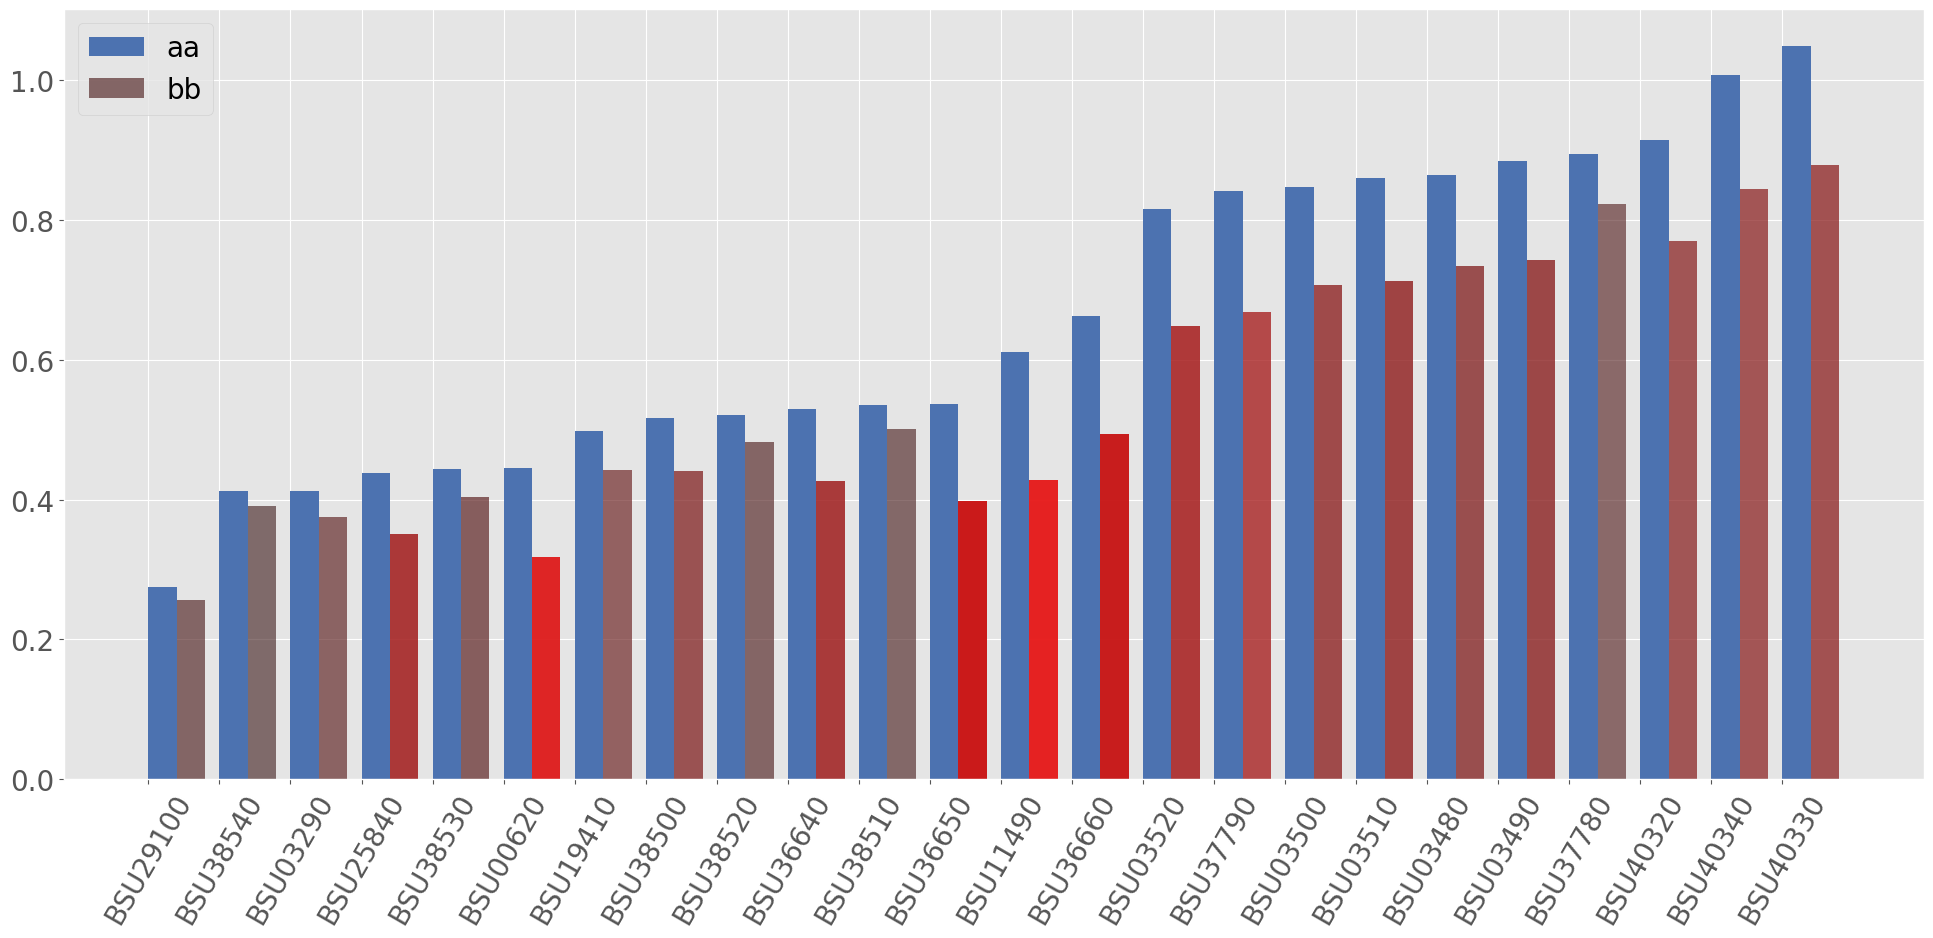

In [138]:


fig, ax = plt.subplots()
fig.set_size_inches(24,10)

bar_width = 0.4
ax.bar(range(len(model_comp_df)), model_comp_df['network_model_score'], bar_width, align='edge',  label='aa')
ax.bar(np.array(range(len(model_comp_df)))+bar_width, model_comp_df['all_model_score'], bar_width, align='edge', 
       color=[color_mapping(diff, pval) for diff, pval in zip(model_comp_df['score_diff']/model_comp_df['network_model_score'], model_comp_df['score_diff_pval'])], label='bb')

plt.xticks(range(len(model_comp_df)), labels=model_comp_df.index.values, rotation=60, fontsize=20)
plt.yticks(fontsize=20)


plt.legend(fontsize=20)

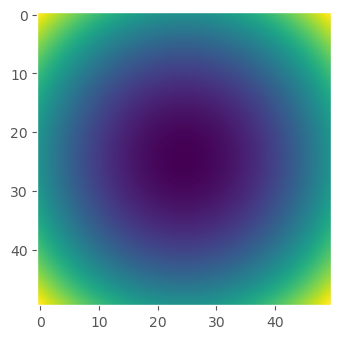

In [145]:
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

def f(x, y):
   return np.array([i * i + j * j for j in y for i in x]).reshape(50, 50)

x = y = np.linspace(-1, 1, 50)
z = f(x, y)

plt.imshow(z, interpolation='bilinear')
plt.style.use(['ggplot'])
plt.grid(False)

plt.show()


In [147]:
z[1,1]

1.840066638900458